In [30]:
import sys
sys.executable

'D:\\Anaconda3\\envs\\gpwork\\python.exe'

* Документация по [History Callback](https://keras.io/callbacks/#history) на сайте Keras.
* Страница [TensorBoard]()

# Подключение библиотек

In [31]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.keras.utils import to_categorical
from tensorflow.keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Подключения библиотеки для разделения данных

In [32]:
from sklearn.model_selection import train_test_split

# TensorBoard and CallBacks

In [33]:
tensorboard = TensorBoard(log_dir='\tb_logs', histogram_freq=1, write_graph=True)
callback_list = [tensorboard]
print("TensorBoard and CallBacks init successful")

TensorBoard and CallBacks init successful


# Функция загрузки сигнала, Train и Test

In [41]:
def create_dataset(filepath):
    sgn = []
    lbl = []
    path = filepath + "/{}_data.txt"
    for i in range(0,10):
        data = np.loadtxt(path.format(i+1), dtype=np.float64)
        for j in range(np.shape(data)[0]):
            sgn.append(data[j, :])
            lbl.append(i)
    
    c = list(zip(sgn, lbl))
    shuffle(c)
    sgn, lbl = zip(*c)

    sgn = np.asarray(sgn, dtype=np.float64)
    lbl = np.asarray(lbl, dtype=np.int64)

    train_signals = sgn[0:int(0.6*len(sgn))]
    train_labels = lbl[0:int(0.6*len(lbl))]
    val_signals = sgn[int(0.6*len(sgn)):int(0.8*len(sgn))]
    val_labels = lbl[int(0.6*len(lbl)):int(0.8*len(lbl))]
    test_signals = sgn[int(0.8*len(sgn)):]
    test_labels = lbl[int(0.8*len(lbl)):]

    nrows, ncols = train_signals.shape
    train_signals = train_signals.reshape(nrows, ncols, 1)
    nrows, ncols = val_signals.shape
    val_signals = val_signals.reshape(nrows, ncols, 1)
    nrows, ncols = test_signals.shape
    test_signals = test_signals.reshape(nrows, ncols, 1)
    
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    test_labels = to_categorical(test_labels)

    return train_signals, train_labels, val_signals, val_labels, test_signals, test_labels

# Функция отображения метрик

In [143]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

In [229]:
test_samples = 158

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 8))
    for i, idx in enumerate(list(np.arange(0, test_samples, 22))):
        # display original
        ax = plt.subplot(4, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx], "r")
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)

# Load data

In [42]:
files_path = "C:/Users/leoska/data_emg/" #path to your directory with 10 data.txt files
train_signals, train_labels, val_signals, val_labels, test_signals, test_labels = create_dataset(files_path)

print("Load data successful")

Load data successful


# Init train and test data

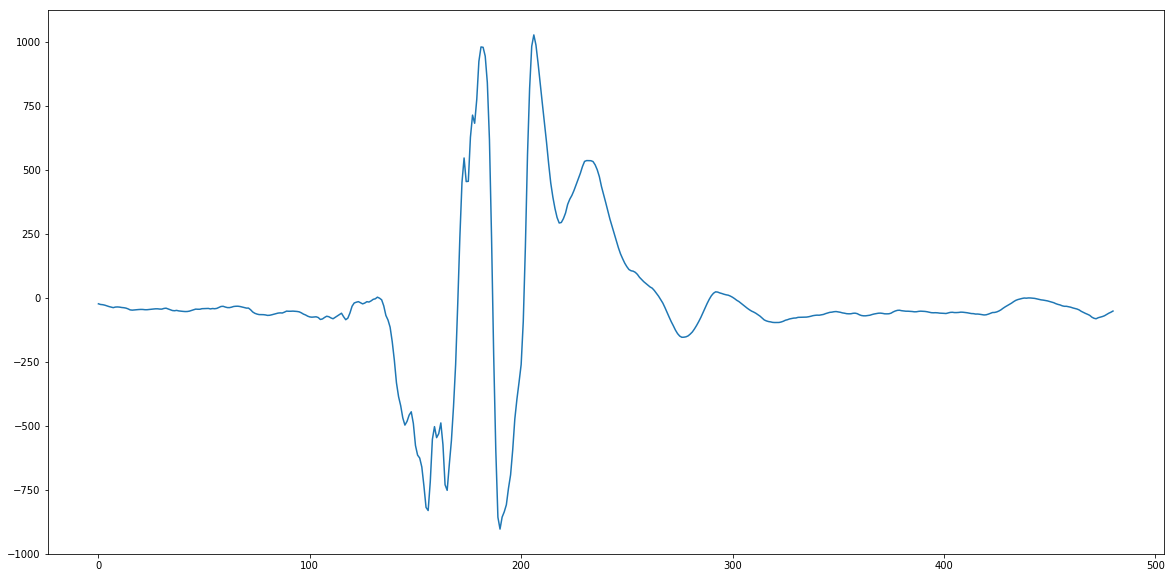

In [43]:
plt.figure(figsize=(20,10))
plt.plot(train_signals[2])
#plt.legend()

# Percentage of test data

In [46]:
print("Percentage of test data: {}%".format((test_size / len(test_signals)) * 100))

Percentage of test data: 0.2088607594936709%


In [162]:
print("Train signal shape: " + str(train_signals.shape))
print("Train labels shape: " + str(train_labels.shape))
print("Test signal shape: " + str(test_signals.shape))
print("Test labels shape: " + str(test_labels.shape))
print("Val signal shape: " + str(val_signals.shape))
print("Val labels shape: " + str(val_labels.shape))



Train signal shape: (474, 481, 1)
Train labels shape: (474, 10)
Test signal shape: (158, 481, 1)
Test labels shape: (158, 10)
Val signal shape: (158, 481, 1)
Val labels shape: (158, 10)


(474, 481, 1)
(158, 481, 1)
(158, 481, 1)
(474, 481)
(158, 481)
(158, 481)
Tensor("input_81:0", shape=(None, 481), dtype=float32)


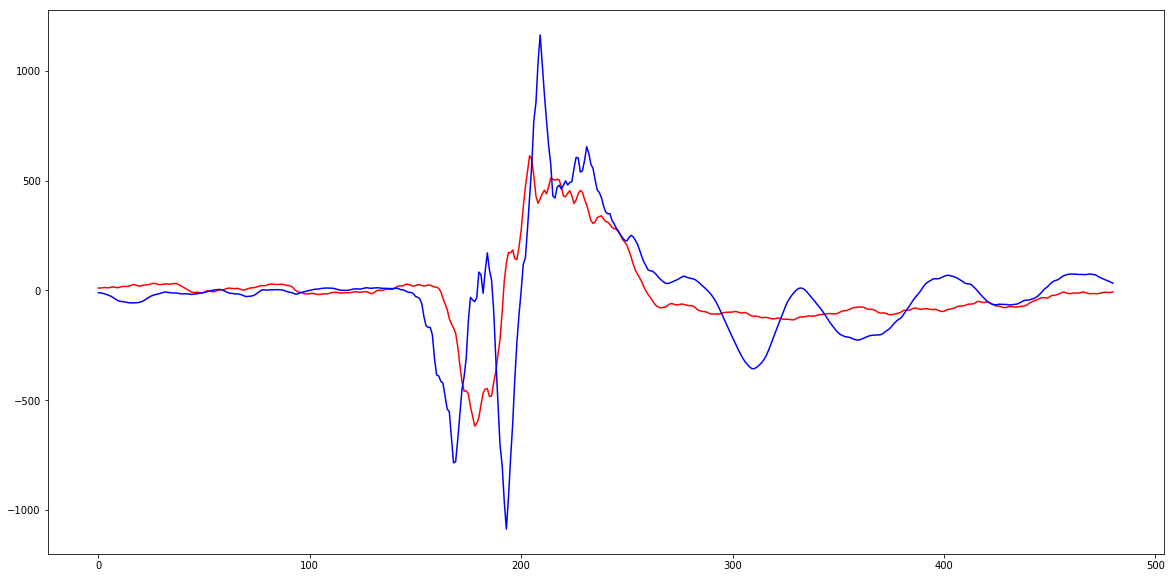

In [254]:
print(train_signals.shape)
print(test_signals.shape)
print(val_signals.shape)

x_train_simple = np.asarray(train_signals).reshape((len(train_signals), np.prod(np.asarray(train_signals).shape[1:])))
y_train_simple = np.asarray(train_labels).reshape((len(train_labels), np.prod(np.asarray(train_labels).shape[1:])))
x_test_simple = np.asarray(test_signals).reshape((len(test_signals), np.prod(np.asarray(test_signals).shape[1:])))
y_test_simple = np.asarray(test_labels).reshape((len(test_labels), np.prod(np.asarray(test_labels).shape[1:])))
x_val_simple = np.asarray(val_signals).reshape((len(val_signals), np.prod(np.asarray(val_signals).shape[1:])))

#print(x_train_simple.shape)
print(np.asarray(x_train_simple).shape)
print(np.asarray(x_test_simple).shape)
print(np.asarray(x_val_simple).shape)

plt.figure(figsize=(20,10))
plt.plot(x_train_simple[3] ,'r')
plt.plot(x_test_simple[3] ,'b')

print(input_window)

# Настройки входого сигнала

Произошла одна эпоха (*epoch*) — весь датасет прошел через нейронную сеть в прямом и обратном направлении только один раз.

Так как одна *epoch* слишком велика для компьютера, датасет делят на маленькие партии (*batches*).

Недостаточно одного полного прохода датасета через нейронную сеть, поэтому используем эпохи.

Нужно помнить, что мы используем ограниченный датасет, чтобы оптимизировать обучение и восстановить кривую сигнала.

In [273]:
# длина сигнала
signal_len = 481
# количество сигналов
signal_count = 474
# количество каналов
inChannel = 1

# Hidden size (размер сжатого слоя слоя)
encoding_dim = 128
epochs = 100 # 5 эпох обучения
batch_size = 1024 #
num_classes = 10


# Simple feed-forward autoencoder

In [289]:
# this is our input placeholder
# 481 -  это размер одного сигнала
input_window = Input(shape=(signal_len, 1))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_window)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(1, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()
# mse - mean_squared_error
# metrics=['accuracy']
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = autoencoder.fit(train_signals, train_signals,
                steps_per_epoch=10,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(val_signals, val_signals),
                validation_steps = 10,
                verbose=1)

decoded_stocks = autoencoder.predict(test_signals)

Model: "model_210"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       [(None, 481, 1)]          0         
_________________________________________________________________
dense_258 (Dense)            (None, 481, 128)          256       
_________________________________________________________________
dense_259 (Dense)            (None, 481, 1)            129       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - ETA: 3s - loss: 147533.6406 - accuracy: 0.0000e+0 - ETA: 3s - loss: 147457.9375 - accuracy: 0.0000e+0 - ETA: 2s - loss: 147427.6094 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147410.2656 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147383.1750 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147349.2031 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147323.9

Epoch 13/100
10/10 [==============================] - ETA: 2s - loss: 147166.0156 - accuracy: 0.0000e+0 - ETA: 2s - loss: 147166.0156 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147166.0156 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147166.0156 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147166.0156 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147166.0130 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147166.0112 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147166.0098 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147166.0087 - accuracy: 0.0000e+0 - 3s 302ms/step - loss: 147166.0078 - accuracy: 0.0000e+00 - val_loss: 122050.5000 - val_accuracy: 0.0000e+00
Epoch 14/100
10/10 [==============================] - ETA: 2s - loss: 147166.0000 - accuracy: 0.0000e+0 - ETA: 2s - loss: 147166.0000 - accuracy: 0.0000e+0 - ETA: 2s - loss: 147166.0000 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.9961 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.9937 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.9922 - accuracy: 0.0000e+0 - ETA:

Epoch 39/100
10/10 [==============================] - ETA: 2s - loss: 147165.5781 - accuracy: 0.0000e+0 - ETA: 2s - loss: 147165.5781 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.5781 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.5781 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.5781 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.5781 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147165.5781 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147165.5781 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147165.5781 - accuracy: 0.0000e+0 - 3s 294ms/step - loss: 147165.5781 - accuracy: 0.0000e+00 - val_loss: 122050.0547 - val_accuracy: 0.0000e+00
Epoch 40/100
10/10 [==============================] - ETA: 2s - loss: 147165.5781 - accuracy: 0.0000e+0 - ETA: 2s - loss: 147165.5703 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.5677 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.5664 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.5656 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.5651 - accuracy: 0.0000e+0 - ETA:

Epoch 65/100
10/10 [==============================] - ETA: 2s - loss: 147165.3906 - accuracy: 0.0000e+0 - ETA: 2s - loss: 147165.3906 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.3906 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.3906 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.3875 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.3854 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147165.3839 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147165.3828 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147165.3819 - accuracy: 0.0000e+0 - 3s 295ms/step - loss: 147165.3813 - accuracy: 0.0000e+00 - val_loss: 122049.8516 - val_accuracy: 0.0000e+00
Epoch 66/100
10/10 [==============================] - ETA: 2s - loss: 147165.3750 - accuracy: 0.0000e+0 - ETA: 2s - loss: 147165.3750 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.3750 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.3750 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.3750 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.3750 - accuracy: 0.0000e+0 - ETA:

Epoch 91/100
10/10 [==============================] - ETA: 2s - loss: 147165.2812 - accuracy: 0.0000e+0 - ETA: 2s - loss: 147165.2812 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.2760 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.2734 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.2719 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.2708 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147165.2701 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147165.2695 - accuracy: 0.0000e+0 - ETA: 0s - loss: 147165.2691 - accuracy: 0.0000e+0 - 3s 295ms/step - loss: 147165.2688 - accuracy: 0.0000e+00 - val_loss: 122049.7266 - val_accuracy: 0.0000e+00
Epoch 92/100
10/10 [==============================] - ETA: 2s - loss: 147165.2656 - accuracy: 0.0000e+0 - ETA: 2s - loss: 147165.2656 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.2656 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.2656 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.2656 - accuracy: 0.0000e+0 - ETA: 1s - loss: 147165.2656 - accuracy: 0.0000e+0 - ETA:

# Plot history (Simple feed-forward autoencoder)

(158, 481, 1)
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


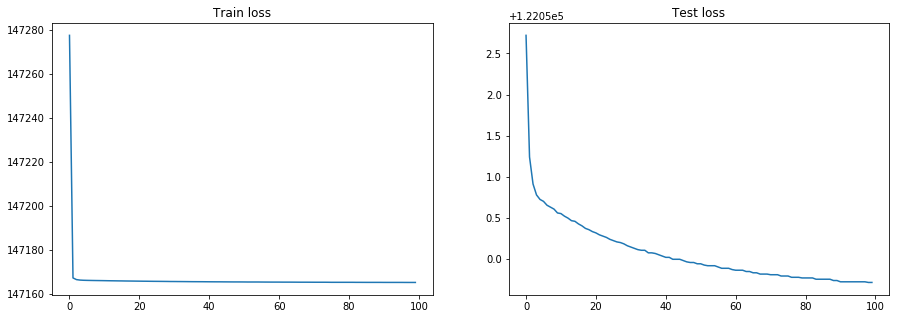

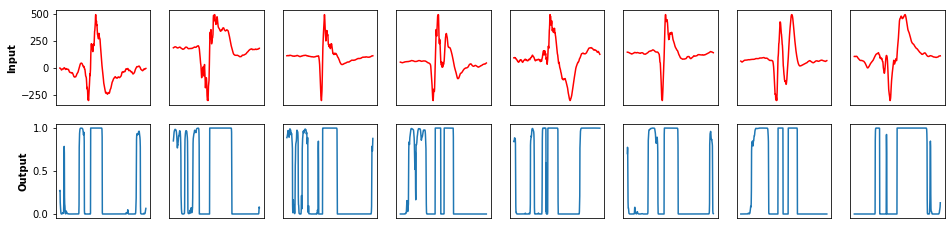

In [290]:
print(decoded_stocks.shape)
print(history.history.keys())

plot_history(history)

plot_examples(x_test_simple, decoded_stocks)


# Deep autoencoder

In [292]:
x_train_deep = np.asarray(train_signals).reshape((len(train_signals), np.prod(np.asarray(train_signals).shape[1:])))
x_test_deep = np.asarray(test_signals).reshape((len(test_signals), np.prod(np.asarray(test_signals).shape[1:])))

input_window = Input(shape=(signal_len, 1))

x = Dense(encoding_dim, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim / 2, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(encoding_dim, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(1, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = autoencoder.fit(train_signals, train_signals,
                steps_per_epoch=10,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(val_signals, val_signals),
                validation_steps = 10,
                verbose=1)

decoded_stocks = autoencoder.predict(test_signals)

Model: "model_214"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_110 (InputLayer)       [(None, 481, 1)]          0         
_________________________________________________________________
dense_264 (Dense)            (None, 481, 128)          256       
_________________________________________________________________
batch_normalization_v2_48 (B (None, 481, 128)          512       
_________________________________________________________________
dense_265 (Dense)            (None, 481, 64)           8256      
_________________________________________________________________
dense_266 (Dense)            (None, 481, 128)          8320      
_________________________________________________________________
batch_normalization_v2_49 (B (None, 481, 128)          512       
_________________________________________________________________
dense_267 (Dense)            (None, 481, 1)            12

10/10 [==============================] - ETA: 20s - loss: 147165.2188 - accuracy: 0.0000e+ - ETA: 18s - loss: 147165.2188 - accuracy: 0.0000e+ - ETA: 15s - loss: 147165.2188 - accuracy: 0.0000e+ - ETA: 13s - loss: 147165.2188 - accuracy: 0.0000e+ - ETA: 11s - loss: 147165.2188 - accuracy: 0.0000e+ - ETA: 9s - loss: 147165.2188 - accuracy: 0.0000e+00 - ETA: 6s - loss: 147165.2188 - accuracy: 0.0000e+0 - ETA: 4s - loss: 147165.2188 - accuracy: 0.0000e+0 - ETA: 2s - loss: 147165.2188 - accuracy: 0.0000e+0 - 25s 3s/step - loss: 147165.2188 - accuracy: 0.0000e+00 - val_loss: 122070.0625 - val_accuracy: 0.0000e+00
Epoch 26/100
10/10 [==============================] - ETA: 20s - loss: 147165.2188 - accuracy: 0.0000e+ - ETA: 18s - loss: 147165.2188 - accuracy: 0.0000e+ - ETA: 15s - loss: 147165.2188 - accuracy: 0.0000e+ - ETA: 13s - loss: 147165.2188 - accuracy: 0.0000e+ - ETA: 11s - loss: 147165.2188 - accuracy: 0.0000e+ - ETA: 9s - loss: 147165.2188 - accuracy: 0.0000e+00 - ETA: 6s - loss: 1

10/10 [==============================] - ETA: 20s - loss: 147165.1250 - accuracy: 0.0000e+ - ETA: 17s - loss: 147165.1250 - accuracy: 0.0000e+ - ETA: 15s - loss: 147165.1250 - accuracy: 0.0000e+ - ETA: 13s - loss: 147165.1250 - accuracy: 0.0000e+ - ETA: 11s - loss: 147165.1250 - accuracy: 0.0000e+ - ETA: 8s - loss: 147165.1250 - accuracy: 0.0000e+00 - ETA: 6s - loss: 147165.1250 - accuracy: 0.0000e+0 - ETA: 4s - loss: 147165.1250 - accuracy: 0.0000e+0 - ETA: 2s - loss: 147165.1250 - accuracy: 0.0000e+0 - 25s 2s/step - loss: 147165.1250 - accuracy: 0.0000e+00 - val_loss: 122051.0078 - val_accuracy: 0.0000e+00
Epoch 52/100
10/10 [==============================] - ETA: 20s - loss: 147165.1250 - accuracy: 0.0000e+ - ETA: 17s - loss: 147165.1250 - accuracy: 0.0000e+ - ETA: 15s - loss: 147165.1250 - accuracy: 0.0000e+ - ETA: 13s - loss: 147165.1250 - accuracy: 0.0000e+ - ETA: 11s - loss: 147165.1250 - accuracy: 0.0000e+ - ETA: 8s - loss: 147165.1250 - accuracy: 0.0000e+00 - ETA: 6s - loss: 1

ResourceExhaustedError: OOM when allocating tensor with shape[474,481,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node training_46/Adam/gradients/batch_normalization_v2_49/moments/mean_grad/Tile}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_172675]

# Plot history (Deep autoencoder)

(158, 481)
dict_keys(['loss', 'val_loss'])


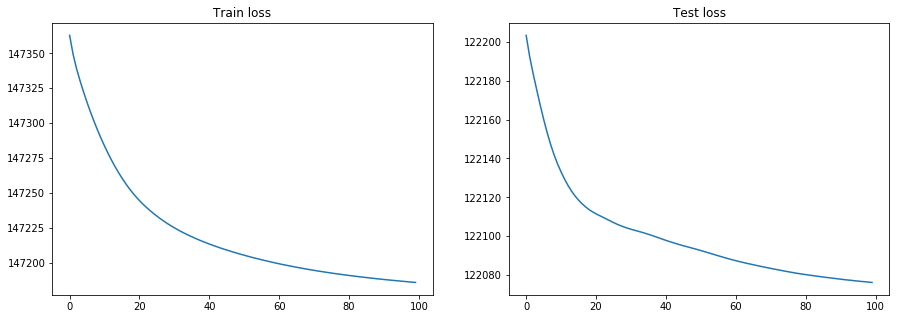

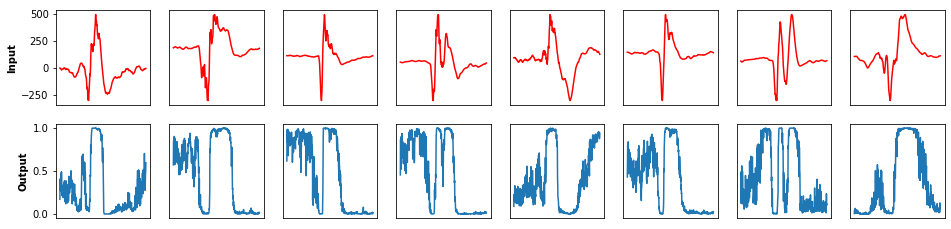

In [264]:
print(decoded_stocks.shape)
print(history.history.keys())

plot_history(history)

plot_examples(x_test_simple, decoded_stocks)


# 1D Convolutional autoencoder (Здесь не правил - нужно грамотно настраивать слои)

In [12]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 1)              49        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 1)              0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 1)              4         
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 6, 1)              0         
__________

30121/30121 [==============================] - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - 1s 28us/step - loss: 0.6244 - val_loss: 0.6279
Epoch 33/100
30121/30121 [==============================] - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.624 - 1s 28us/step - loss: 0.6241 - val_loss: 0.6276
Epoch 34/100
30121/30121 [==============================] - ETA: 0s - loss: 0.625 - ETA: 0s - loss: 0.6

30121/30121 [==============================] - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - 1s 29us/step - loss: 0.6205 - val_loss: 0.6242
Epoch 69/100
30121/30121 [==============================] - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.619 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - 1s 28us/step - loss: 0.6205 - val_loss: 0.6243
Epoch 70/100
30121/30121 [==============================] - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.6

# Plot history (1D Convolutional autoencoder)

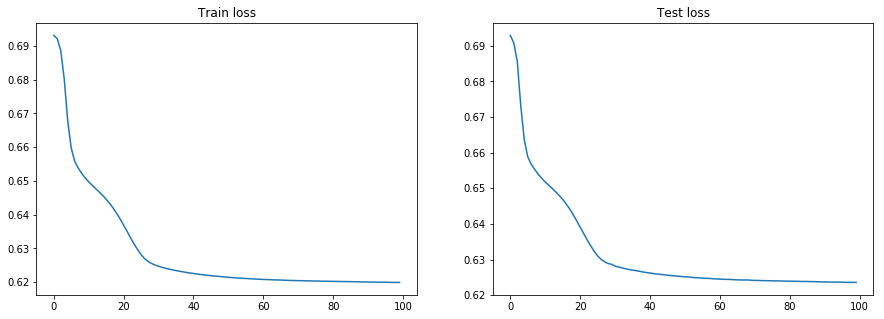

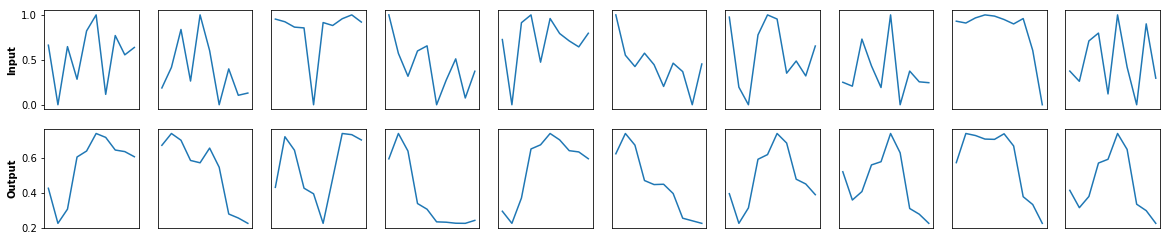

In [13]:
plot_history(history)
plot_examples(x_test_simple, decoded_stocks)